# <font color='red' face='Times New Roman' size=15>**Predicting the Toxicity Level of Pesticides to** ***Eisenia fetida*** **based on the Machine Learning Method**</font>

## **The following is an example of building three-class classification models in the article, due to the author's limited level, there are inevitably flaws in the modeling process, do not blame!**

### The process of building three-class classification models for predicting the toxicity of pesticides to *Eisenia fetida* is shown below:

#### To import the required libraries, the versions of the various Python packages (except pickle) are listed below:
|Package|Version|
|:---:|:---:|
|bayesian-optimization|1.4.3|
|imbalanced-learn|0.12.3|
|lightgbm|4.4.0|
|matplotlib|3.9.0|
|mordredcommunity|2.0.6|
|numpy|1.26.4|
|pandas|2.2.2|
|rdkit|2023.9.6|
|scikit-learn|1.5.0|
|seaborn|0.13.2|
|shap|0.45.1|
|xgboost|2.1.0|

In [68]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import shap
from modeling import *

#### Imported the dataset, calculated molecular representations; one-hot encode the pesticide formulations because we wanted to know how each formulation affected the toxicity of the pesticides to *Eisenia fetida*

In [69]:
pesticides_data = pd.read_excel('Supporting Information.xlsx', header=1, sheet_name='Table S5')

model_data = compute_mordred(pesticides_data)  ##  计算 Mordred 分子描述符
# model_data = compute_rdkit(pesticides_data)  ##  计算 RDKit 分子描述符
# model_data = compute_morgan(pesticides_data)  ##  计算 count-based Morgan 分子指纹

dosage_form = pd.get_dummies(model_data['Dosage Form'], dtype=int)
model_data = pd.concat([dosage_form, model_data], axis=1)
model_data.drop(['Dosage Form', 'English Name', 'CAS Number'], axis=1, inplace=True)

model_data

100%|██████████| 573/573 [00:15<00:00, 38.20it/s]


,AS,CJ,CS,EC,EW,FU,GR,ME,OD,PP,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,0,0,0,0,0,0,0,0,...,10.433792,76.232991,354.101585,8.636624,1525.0,49.0,144.0,178.0,8.722222,5.694444
1,0,0,0,0,0,0,0,0,0,0,...,9.659440,45.904399,263.881559,18.848683,272.0,25.0,68.0,82.0,7.166667,3.333333
2,0,0,0,1,0,0,0,0,0,0,...,8.448700,38.179718,169.014009,9.389667,139.0,7.0,42.0,40.0,5.923611,2.208333
3,0,0,0,1,0,0,0,0,0,0,...,8.448700,38.179718,169.014009,9.389667,139.0,7.0,42.0,40.0,5.923611,2.208333
4,0,0,0,1,0,0,0,0,0,0,...,8.448700,38.179718,169.014009,9.389667,139.0,7.0,42.0,40.0,5.923611,2.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0,0,0,0,1,0,0,0,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667
569,0,0,0,0,0,0,0,1,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667
570,0,0,0,0,0,0,0,1,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667
571,0,0,0,0,0,0,0,1,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667


#### Stratified sampling in the ratio of 8:2 to divide the training and test sets

In [70]:
X_train, X_test, y_train, y_test = data_split(model_data, 'toxicity_14')

extrainfo_train = X_train.iloc[:, :22].reset_index(drop=True)
extrainfo_test = X_test.iloc[:, :22].reset_index(drop=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

feature_names = X_train.columns.tolist()

#### Distribution of training and test sets

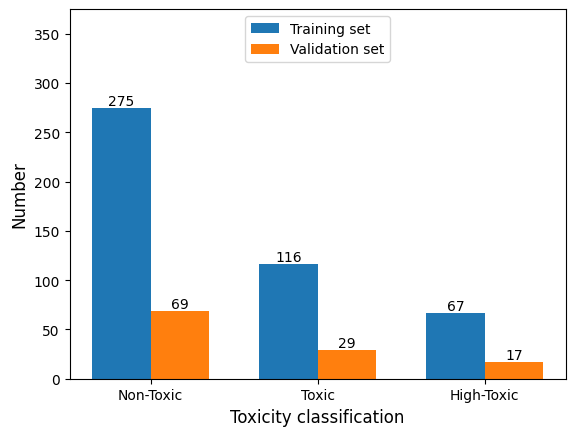

In [71]:
num0 = len(y_train[y_train == 0])
num1 = len(y_train[y_train == 1])
num2 = len(y_train[y_train == 2])

num4 = len(y_test[y_test == 0])
num5 = len(y_test[y_test == 1])
num6 = len(y_test[y_test == 2])

data1 = [num0, num1, num2]
data2 = [num4, num5, num6]
categories = ['Non-Toxic', 'Toxic', 'High-Toxic']
bar_width = 0.35
bar_positions_group1 = np.arange(len(categories))
bar_positions_group2 = bar_positions_group1 + bar_width

plt.figure()
bars1 = plt.bar(bar_positions_group1, data1, width=bar_width, label='Training set')
for bar, data in zip(bars1, data1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), data, ha='center', va='bottom')

bars2 = plt.bar(bar_positions_group2, data2, width=bar_width, label='Validation set')
for bar, data in zip(bars2, data2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), data, ha='center', va='bottom')

plt.xticks(bar_positions_group1 + bar_width / 2, categories)
plt.xlabel('Toxicity classification', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.ylim(0, 375)
plt.legend(loc='upper center')
plt.show()

#### Use XGBoost to select the 10 most important features

In [72]:
model_select_feature = XGBClassifier(seed=0)
num_features = 10

X_train, X_test, features_selected = feature_selection(model_select_feature, num_features, X_train, y_train, X_test)

print(f"We select {len(features_selected)} features as follows: \n {features_selected}")

We select 10 features as follows: 
        Features
0       MATS3se
1        GATS2s
2        GATS1m
3     SpMAD_Dzv
4         C1SP2
5          SIC5
6  FilterItLogS
7        nFRing
8         SLogP
9          GGI1


#### Evaluate the correlation between these 10 descriptors

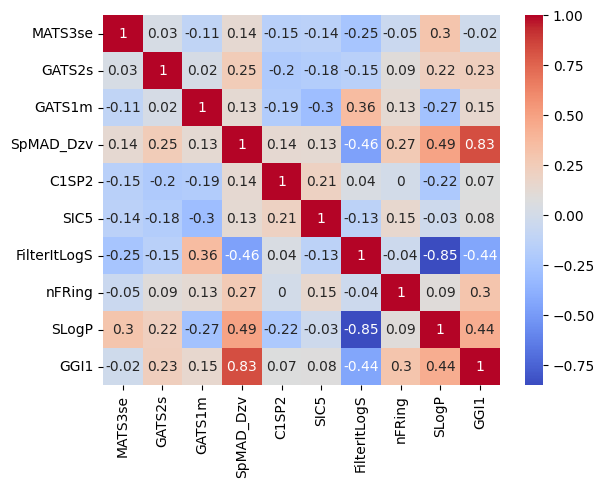

In [73]:
corr_matrix = X_train.corr()
corr_matrix = corr_matrix.round(2)

plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Remove one of the strongly correlated molecular descriptor pairs (Pearson's correlation coefficient greater than 0.8) and merge soil properties and pesticide formulations

In [74]:
X_train.drop(columns=['FilterItLogS', 'SpMAD_Dzv'], inplace=True)
X_test.drop(columns=['FilterItLogS', 'SpMAD_Dzv'], inplace=True)

X_train = pd.concat([X_train, extrainfo_train], axis=1)
X_test = pd.concat([X_test, extrainfo_test], axis=1)

#### Define the models; build the pipelines

In [75]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

scaler = StandardScaler()
smote = SMOTE(random_state=0)

models = [
    LogisticRegression(random_state=0),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(probability=True, random_state=0),
    DecisionTreeClassifier(random_state=0),
    BaggingClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    LGBMClassifier(verbose=-1, random_state=0),
]

modelnames = [
    'Logistic Regression', 'Linear Discriminant Analysis', 'Gaussian Naive Bayes', 'K-nearest Neighbor', 
    'Supporting Vector Machine', 'Decision Tree', 'Bagging', 'Random Forest', 'Gradient Boosting',
    'Light Gradient Boosting Machine'
]

ppls = []

for model, name in zip(models, modelnames): 
    if isinstance(model, (LogisticRegression, LinearDiscriminantAnalysis,
                          GaussianNB, KNeighborsClassifier, SVC)):
        ppl = make_pipeline(scaler, smote, model)
        ppls.append(ppl)
    else:
        ppl = make_pipeline(smote, model)
        ppls.append(ppl)

#### Train the models with the default hyperparameters and use the test set to evaluate

Logistic Regression's results of 10-fold cross-validation are as follows: 
 [0.45238095 0.4701865  0.6346094  0.50033223 0.58380952 0.56589744
 0.52172365 0.43362069 0.46559733 0.46222222] 

Logistic Regression's mean result of 10-fold cross-validation is 0.509
Logistic Regression's Matthews Correlation Coefficient is 0.309 

Logistic Regression's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.80      0.58      0.67        69
           1       0.38      0.52      0.43        29
           2       0.40      0.59      0.48        17

    accuracy                           0.57       115
   macro avg       0.53      0.56      0.53       115
weighted avg       0.63      0.57      0.58       115



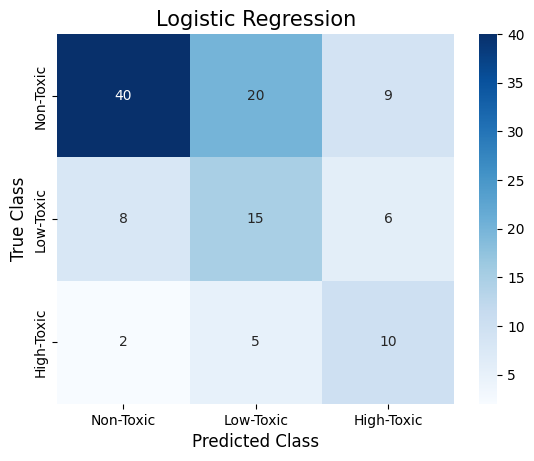

Linear Discriminant Analysis's results of 10-fold cross-validation are as follows: 
 [0.47006803 0.46332607 0.62095238 0.49061149 0.56291645 0.56589744
 0.48730118 0.47049808 0.54576441 0.44577201] 

Linear Discriminant Analysis's mean result of 10-fold cross-validation is 0.512
Linear Discriminant Analysis's Matthews Correlation Coefficient is 0.301 

Linear Discriminant Analysis's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.80      0.57      0.66        69
           1       0.38      0.52      0.44        29
           2       0.37      0.59      0.45        17

    accuracy                           0.56       115
   macro avg       0.52      0.56      0.52       115
weighted avg       0.63      0.56      0.58       115



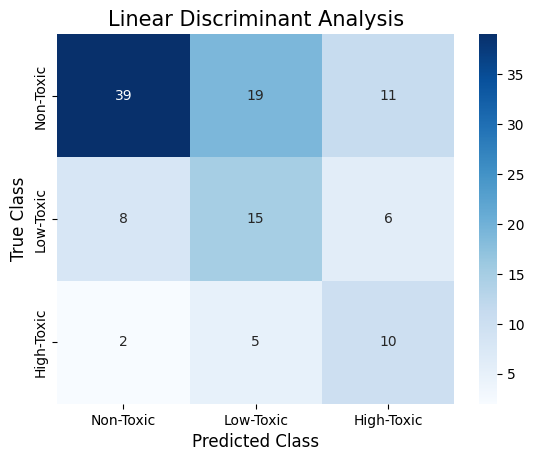

Gaussian Naive Bayes's results of 10-fold cross-validation are as follows: 
 [0.16646754 0.24135802 0.16333938 0.16507937 0.18024691 0.44224741
 0.36135329 0.17881322 0.20679012 0.19321895] 

Gaussian Naive Bayes's mean result of 10-fold cross-validation is 0.23
Gaussian Naive Bayes's Matthews Correlation Coefficient is -0.0402 

Gaussian Naive Bayes's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.40      0.03      0.05        69
           1       0.24      0.86      0.37        29
           2       0.50      0.12      0.19        17

    accuracy                           0.25       115
   macro avg       0.38      0.34      0.20       115
weighted avg       0.37      0.25      0.15       115



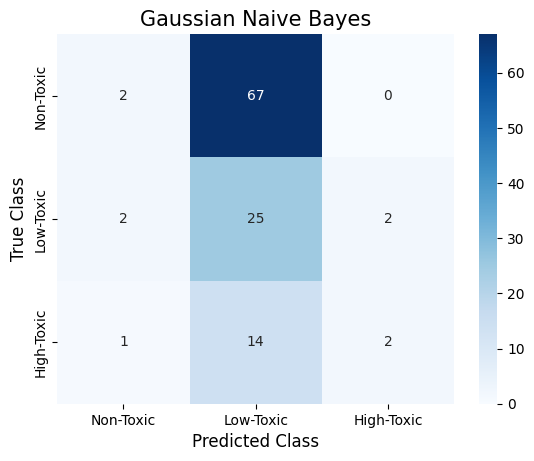

K-nearest Neighbor's results of 10-fold cross-validation are as follows: 
 [0.44827586 0.54643791 0.65860806 0.6370886  0.44555053 0.57847873
 0.52068084 0.5472805  0.46333333 0.44935374] 

K-nearest Neighbor's mean result of 10-fold cross-validation is 0.53
K-nearest Neighbor's Matthews Correlation Coefficient is 0.219 

K-nearest Neighbor's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.74      0.54      0.62        69
           1       0.31      0.45      0.37        29
           2       0.39      0.53      0.45        17

    accuracy                           0.51       115
   macro avg       0.48      0.50      0.48       115
weighted avg       0.58      0.51      0.53       115



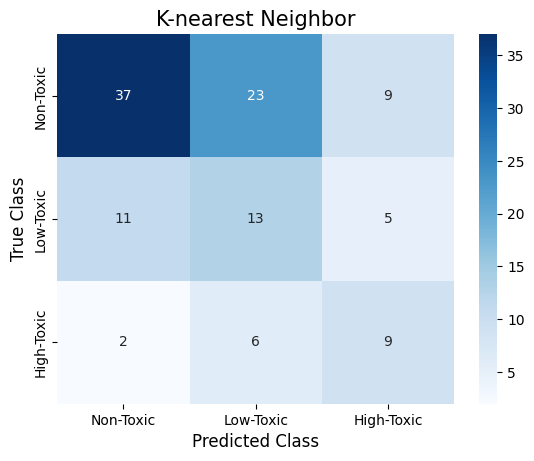

Supporting Vector Machine's results of 10-fold cross-validation are as follows: 
 [0.53267974 0.47857143 0.67144294 0.62626263 0.56153042 0.59714286
 0.56941176 0.50837743 0.53868713 0.50350877] 

Supporting Vector Machine's mean result of 10-fold cross-validation is 0.559
Supporting Vector Machine's Matthews Correlation Coefficient is 0.374 

Supporting Vector Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.81      0.64      0.72        69
           1       0.42      0.62      0.50        29
           2       0.50      0.53      0.51        17

    accuracy                           0.62       115
   macro avg       0.58      0.60      0.58       115
weighted avg       0.67      0.62      0.63       115



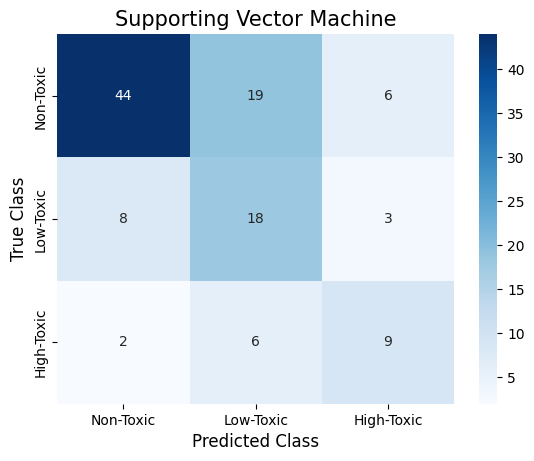

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.63997639 0.56349206 0.66910867 0.66523535 0.56592127 0.7232078
 0.80017774 0.58585859 0.58086526 0.67000835] 

Decision Tree's mean result of 10-fold cross-validation is 0.646
Decision Tree's Matthews Correlation Coefficient is 0.455 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        69
           1       0.48      0.48      0.48        29
           2       0.50      0.53      0.51        17

    accuracy                           0.70       115
   macro avg       0.61      0.61      0.61       115
weighted avg       0.70      0.70      0.70       115



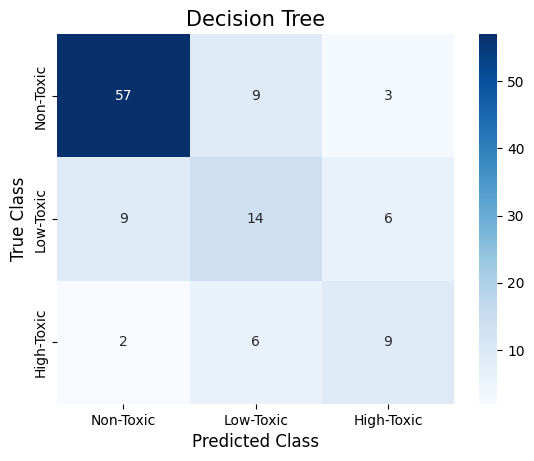

Bagging's results of 10-fold cross-validation are as follows: 
 [0.82662338 0.54801865 0.7810366  0.64578112 0.58663004 0.7288699
 0.74108947 0.63373016 0.71170339 0.72434087] 

Bagging's mean result of 10-fold cross-validation is 0.693
Bagging's Matthews Correlation Coefficient is 0.476 

Bagging's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        69
           1       0.53      0.59      0.56        29
           2       0.59      0.59      0.59        17

    accuracy                           0.70       115
   macro avg       0.65      0.65      0.65       115
weighted avg       0.71      0.70      0.71       115



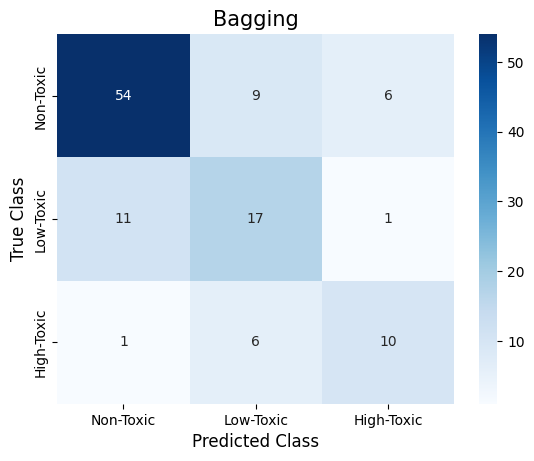

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.76847132 0.58364413 0.7282542  0.73545803 0.61227106 0.7288699
 0.74343434 0.63373016 0.72005772 0.74255511] 

Random Forest's mean result of 10-fold cross-validation is 0.7
Random Forest's Matthews Correlation Coefficient is 0.597 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        69
           1       0.63      0.59      0.61        29
           2       0.79      0.65      0.71        17

    accuracy                           0.78       115
   macro avg       0.75      0.71      0.73       115
weighted avg       0.78      0.78      0.78       115



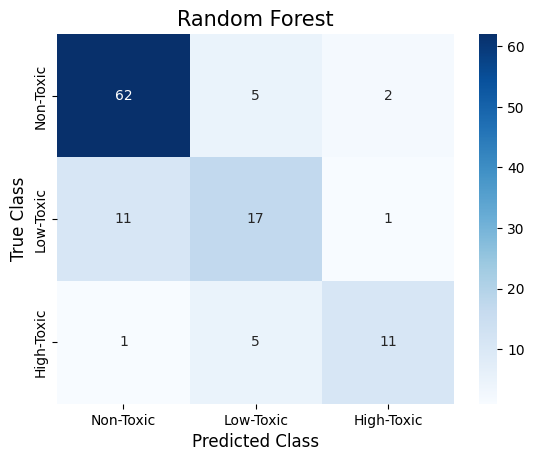

Gradient Boosting's results of 10-fold cross-validation are as follows: 
 [0.65343915 0.51690455 0.78571429 0.69365164 0.59541446 0.74323232
 0.7615304  0.53528097 0.68014669 0.59591998] 

Gradient Boosting's mean result of 10-fold cross-validation is 0.656
Gradient Boosting's Matthews Correlation Coefficient is 0.573 

Gradient Boosting's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        69
           1       0.61      0.66      0.63        29
           2       0.64      0.53      0.58        17

    accuracy                           0.77       115
   macro avg       0.70      0.68      0.69       115
weighted avg       0.76      0.77      0.76       115



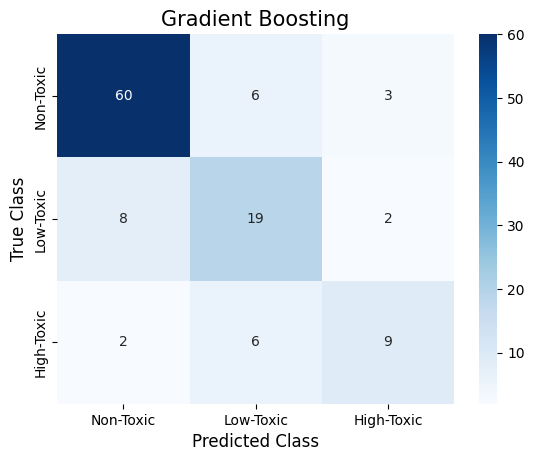

Light Gradient Boosting Machine's results of 10-fold cross-validation are as follows: 
 [0.72693032 0.58911772 0.77204586 0.68974359 0.58139232 0.70004838
 0.71675084 0.60473065 0.64814815 0.7010101 ] 

Light Gradient Boosting Machine's mean result of 10-fold cross-validation is 0.673
Light Gradient Boosting Machine's Matthews Correlation Coefficient is 0.637 

Light Gradient Boosting Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89        69
           1       0.66      0.66      0.66        29
           2       0.69      0.65      0.67        17

    accuracy                           0.80       115
   macro avg       0.74      0.73      0.74       115
weighted avg       0.80      0.80      0.80       115



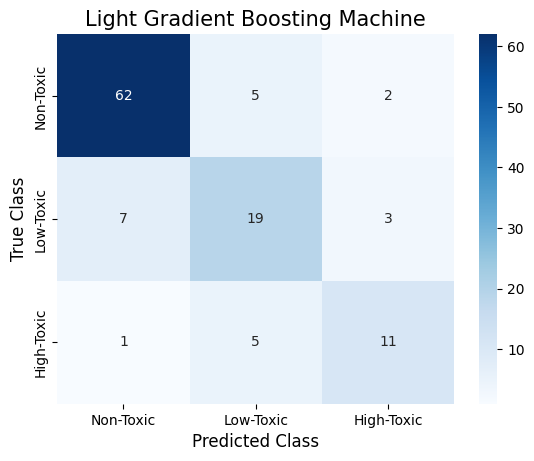

In [23]:
for ppl, name in zip(ppls, modelnames):
    evaluate_model_3class(ppl, X_train, y_train, X_test, y_test, kf, name)

#### Logistic Regression, Bayesian optimization

In [24]:
def black_box_function1(C, max_iter):
    model = LogisticRegression(
        C=float(C),
        max_iter=int(max_iter),
        random_state=0
    )
    
    ppl = make_pipeline(scaler, smote,  model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro')
    
    return cv_score.mean()

pbounds1 = {
    'C': (0.1, 5),
    'max_iter': (50, 500)
}

optimizer1 = BayesianOptimization(
    f=black_box_function1,
    pbounds=pbounds1,
    verbose=2,
    random_state=0
)

optimizer1.maximize(init_points=25, n_iter=75)

best_params1 = optimizer1.max['params']

best_params1['C'] = float('%.3g'%best_params1['C'])
best_params1['max_iter'] = round(best_params1['max_iter'])

print(optimizer1.max)
print(best_params1)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.5095    | 2.789     | 371.8     |
| 2         | 0.5095    | 3.054     | 295.2     |
| 3         | 0.5095    | 2.176     | 340.7     |
| 4         | 0.5095    | 2.244     | 451.3     |
| 5         | 0.5095    | 4.822     | 222.5     |
| 6         | 0.5095    | 3.979     | 288.0     |
| 7         | 0.5095    | 2.883     | 466.5     |
| 8         | 0.509     | 0.4481    | 89.21     |
| 9         | 0.5194    | 0.1991    | 424.7     |
| 10        | 0.5095    | 3.913     | 441.5     |
| 11        | 0.5095    | 4.895     | 409.6     |
| 12        | 0.5095    | 2.361     | 401.2     |
| 13        | 0.509     | 0.6795    | 338.0     |
| 14        | 0.509     | 0.8024    | 475.1     |
| 15        | 0.5095    | 2.657     | 236.6     |
| 16        | 0.5095    | 1.396     | 398.4     |
| 17        | 0.5095    | 2.335     | 305.8     |
| 18        | 0.5194    | 0.1921    | 327.9     |


#### Evaluation

LR's results of 10-fold cross-validation are as follows: 
 [0.47006803 0.4701865  0.6346094  0.50033223 0.62018141 0.59114386
 0.52172365 0.4462585  0.47739938 0.46222222] 

LR's mean result of 10-fold cross-validation is 0.519
LR's Matthews Correlation Coefficient is 0.328 

LR's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.82      0.58      0.68        69
           1       0.39      0.55      0.46        29
           2       0.40      0.59      0.48        17

    accuracy                           0.57       115
   macro avg       0.54      0.57      0.54       115
weighted avg       0.65      0.57      0.59       115



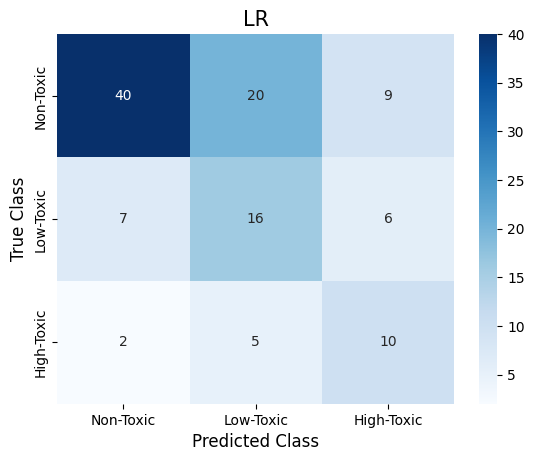

In [25]:
model_1 = LogisticRegression(C = best_params1['C'],
                             max_iter=best_params1['max_iter'],
                             random_state=0)

ppl_1 = make_pipeline(scaler, smote, model_1)

evaluate_model_3class(ppl_1, X_train, y_train, X_test, y_test, kf, 'LR')

#### LDA and GNB have fewer hyperparameters, so we do not tuned their hyperparameters

In [26]:
ppl_2 = make_pipeline(scaler, smote, LinearDiscriminantAnalysis())
ppl_3 = make_pipeline(scaler, smote, GaussianNB())

ppl_2.fit(X_train, y_train)
ppl_3.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('smote', SMOTE(random_state=0)),
                ('gaussiannb', GaussianNB())])

#### KNN, Bayesian optimization

In [27]:
def black_box_function4(n_neighbors):
    model = KNeighborsClassifier(
        n_neighbors=int(n_neighbors),
        weights='uniform',
        algorithm='brute',
        metric='minkowski',
        p=2
    )
    
    ppl = make_pipeline(scaler, smote, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro') 
    
    return cv_score.mean()

pbounds4 = {
    'n_neighbors': (1, 100)
}

optimizer4 = BayesianOptimization(
    f=black_box_function4,
    pbounds=pbounds4,
    verbose=2,
    random_state=0,
    allow_duplicate_points=True
)

optimizer4.maximize(init_points=25, n_iter=75)

best_params4 = optimizer4.max['params']

best_params4['n_neighbors'] = round(best_params4['n_neighbors'])

print(optimizer4.max)
print(best_params4)

|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.4479    | 55.33     |
| 2         | 0.4663    | 71.8      |
| 3         | 0.4587    | 60.67     |
| 4         | 0.4518    | 54.94     |
| 5         | 0.4552    | 42.94     |
| 6         | 0.4467    | 64.94     |
| 7         | 0.4611    | 44.32     |
| 8         | 0.4879    | 89.29     |
| 9         | 0.4864    | 96.4      |
| 10        | 0.457     | 38.96     |
| 11        | 0.4695    | 79.38     |
| 12        | 0.4509    | 53.36     |
| 13        | 0.4543    | 57.24     |
| 14        | 0.4837    | 92.63     |
| 15        | 0.5378    | 8.033     |
| 16        | 0.514     | 9.626     |
| 17        | 0.5407    | 3.002     |
| 18        | 0.4756    | 83.43     |
| 19        | 0.4631    | 78.04     |
| 20        | 0.4897    | 87.13     |
| 21        | 0.4812    | 97.88     |
| 22        | 0.4579    | 80.12     |
| 23        | 0.4587    | 46.69     |
| 24        | 0.4631    | 78.27     |
| 25        

#### Evaluation

KNN's results of 10-fold cross-validation are as follows: 
 [0.5472805  0.54620223 0.66176245 0.5361552  0.52509579 0.67636684
 0.63612236 0.56752137 0.53932981 0.60493827] 

KNN's mean result of 10-fold cross-validation is 0.584
KNN's Matthews Correlation Coefficient is 0.417 

KNN's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        69
           1       0.46      0.55      0.50        29
           2       0.60      0.53      0.56        17

    accuracy                           0.67       115
   macro avg       0.62      0.61      0.61       115
weighted avg       0.68      0.67      0.67       115



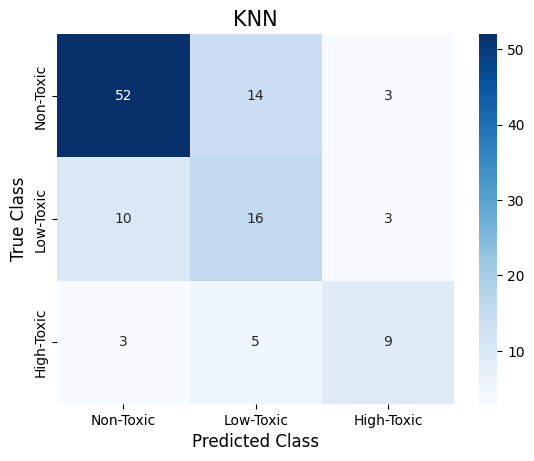

In [28]:
model_4 = KNeighborsClassifier(n_neighbors=best_params4['n_neighbors'],
                               weights='uniform',
                               algorithm='brute',
                               metric='minkowski',
                               p=2)
ppl_4 = make_pipeline(scaler, smote, model_4)

evaluate_model_3class(ppl_4, X_train, y_train, X_test, y_test, kf, 'KNN')

#### SVC, Bayesian optimization

In [29]:
def black_box_function5(C, gamma):
    model = SVC(
        C=float(C),
        gamma=float(gamma),
        kernel='rbf',
        probability=True,
        random_state=0
    )

    ppl = make_pipeline(scaler, smote, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro')

    return cv_score.mean()

pbounds5 = {
    'C' : (1e-3, 10),
    'gamma' : (1e-3, 10)
}

optimizer5 = BayesianOptimization(
    f=black_box_function5,
    pbounds=pbounds5,
    verbose=2,
    random_state=0
)

optimizer5.maximize(init_points=25, n_iter=75)

best_params5 = optimizer5.max['params']

best_params5['C'] = float('%.3g'%best_params5['C'])
best_params5['gamma'] = float('%.3g'%best_params5['gamma'])

print(optimizer5.max)
print(best_params5)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.258     | 5.489     | 7.152     |
| 2         | 0.2794    | 6.028     | 5.449     |
| 3         | 0.2629    | 4.237     | 6.459     |
| 4         | 0.2504    | 4.376     | 8.918     |
| 5         | 0.3173    | 9.637     | 3.835     |
| 6         | 0.2775    | 7.917     | 5.289     |
| 7         | 0.2504    | 5.681     | 9.256     |
| 8         | 0.3807    | 0.7113    | 0.8722    |
| 9         | 0.2501    | 0.2032    | 8.326     |
| 10        | 0.2504    | 7.782     | 8.7       |
| 11        | 0.2499    | 9.786     | 7.992     |
| 12        | 0.2499    | 4.615     | 7.806     |
| 13        | 0.2629    | 1.184     | 6.4       |
| 14        | 0.2504    | 1.434     | 9.447     |
| 15        | 0.3023    | 5.219     | 4.147     |
| 16        | 0.2502    | 2.646     | 7.743     |
| 17        | 0.2743    | 4.562     | 5.685     |
| 18        | 0.2501    | 0.1889    | 6.177     |


#### Evaluation

SVC's results of 10-fold cross-validation are as follows: 
 [0.63142174 0.49888692 0.66633549 0.59322034 0.56296296 0.61730994
 0.6869773  0.59993263 0.50694133 0.57820398] 

SVC's mean result of 10-fold cross-validation is 0.594
SVC's Matthews Correlation Coefficient is 0.381 

SVC's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        69
           1       0.50      0.45      0.47        29
           2       0.78      0.41      0.54        17

    accuracy                           0.68       115
   macro avg       0.67      0.57      0.60       115
weighted avg       0.68      0.68      0.67       115



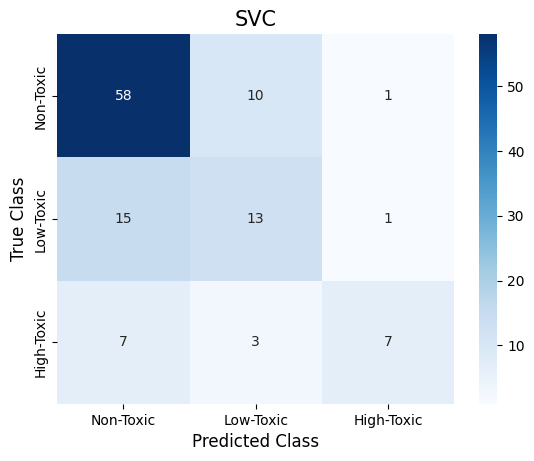

In [30]:
model_5 = SVC(C=best_params5['C'],
              gamma=best_params5['gamma'],
              kernel='rbf', probability=True, random_state=0)

ppl_5 = make_pipeline(scaler, smote, model_5)

evaluate_model_3class(ppl_5, X_train, y_train, X_test, y_test, kf, 'SVC')

#### Decision Tree, Bayesian optimization

In [31]:
def black_box_function6(max_depth, max_features, min_samples_split, min_samples_leaf):
    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=0
    )
    
    pipeline = make_pipeline(smote, model)
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1_macro')

    return cv_score.mean()

pbounds6 = {
    'max_depth':(1,30),
    'max_features':(1,30),
    'min_samples_split':(2,20),
    'min_samples_leaf':(1,20)
}

optimizer6 = BayesianOptimization(
    f=black_box_function6,
    pbounds=pbounds6,
    random_state=0,
)

optimizer6.maximize(init_points=25,n_iter=75)

best_params6 = optimizer6.max['params']

best_params6['max_depth'] = round(best_params6['max_depth'])
best_params6['max_features'] = round(best_params6['max_features'])
best_params6['min_samples_split'] = round(best_params6['min_samples_split'])
best_params6['min_samples_leaf'] = round(best_params6['min_samples_leaf'])

print("Optimized parameters:",optimizer6.max)
print(best_params6)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.6365    | 16.92     | 21.74     | 12.45     | 11.81     |
| 2         | 0.5953    | 13.29     | 19.73     | 9.314     | 18.05     |
| 3         | 0.6149    | 28.95     | 12.12     | 16.04     | 11.52     |
| 4         | 0.6348    | 17.47     | 27.84     | 2.35      | 3.568     |
| 5         | 0.4857    | 1.586     | 25.15     | 15.78     | 17.66     |
| 6         | 0.6102    | 29.38     | 24.18     | 9.768     | 16.05     |
| 7         | 0.5891    | 4.43      | 19.56     | 3.724     | 19.0      |
| 8         | 0.606     | 16.13     | 13.03     | 6.027     | 15.94     |
| 9         | 0.6092    | 14.23     | 17.48     | 1.357     | 13.12     |
| 10        | 0.599     | 18.75     | 18.89     | 18.93     | 14.27     |
| 11        | 0.6105    | 11.43     | 13.67     | 14.25     | 3.084     |
| 12        | 0.6283    | 20.34     | 

#### Evaluation

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.68081761 0.69525402 0.78015195 0.732665   0.61777778 0.76954157
 0.7615304  0.54601247 0.6977657  0.64890414] 

Decision Tree's mean result of 10-fold cross-validation is 0.693
Decision Tree's Matthews Correlation Coefficient is 0.554 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        69
           1       0.53      0.66      0.58        29
           2       0.67      0.71      0.69        17

    accuracy                           0.74       115
   macro avg       0.69      0.71      0.70       115
weighted avg       0.76      0.74      0.75       115



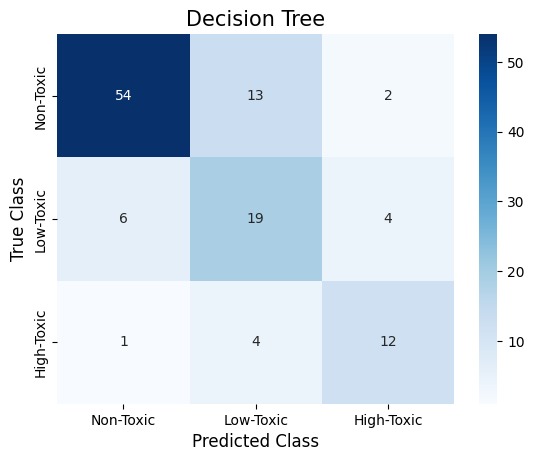

In [32]:
model_6 = DecisionTreeClassifier(max_depth=best_params6['max_depth'],
                                 max_features=best_params6['max_features'],
                                 min_samples_split=best_params6['min_samples_split'],
                                 min_samples_leaf=best_params6['min_samples_leaf'],
                                 random_state=0)
ppl_6 = make_pipeline(smote, model_6)

evaluate_model_3class(ppl_6, X_train, y_train, X_test, y_test, kf, 'Decision Tree')

#### Bagging, Bayesian optimization

In [33]:
def black_box_function7(n_estimators, max_samples, max_features):
    
    model = BaggingClassifier(
        n_estimators=int(n_estimators),
        max_samples=int(max_samples),
        max_features=int(max_features),
        random_state=0
    )

    ppl = make_pipeline(smote, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro')

    return cv_score.mean()

pbounds7 = {
    'n_estimators': (50, 500),
    'max_samples': (50, 300),
    'max_features': (1, 31)
}

optimizer7 = BayesianOptimization(
    f=black_box_function7,
    pbounds=pbounds7,
    verbose=2,
    random_state=0
)

optimizer7.maximize(init_points=25, n_iter=75)
best_params7 = optimizer7.max['params']

best_params7['n_estimators'] = round(best_params7['n_estimators'])
best_params7['max_samples'] = round(best_params7['max_samples'])
best_params7['max_features'] = round(best_params7['max_features'])

print("Optimized parameters:",optimizer7.max)
print(best_params7)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.6671    | 17.46     | 228.8     | 321.2     |
| 2         | 0.6719    | 17.35     | 155.9     | 340.7     |
| 3         | 0.6634    | 14.13     | 272.9     | 483.6     |
| 4         | 0.6797    | 12.5      | 247.9     | 288.0     |
| 5         | 0.6808    | 18.04     | 281.4     | 81.97     |
| 6         | 0.6632    | 3.614     | 55.05     | 424.7     |
| 7         | 0.6643    | 24.34     | 267.5     | 490.4     |
| 8         | 0.6569    | 24.97     | 165.4     | 401.2     |
| 9         | 0.6413    | 4.548     | 210.0     | 114.5     |
| 10        | 0.6527    | 29.34     | 180.5     | 236.6     |
| 11        | 0.6662    | 8.937     | 243.6     | 255.3     |
| 12        | 0.6426    | 18.05     | 54.7      | 327.9     |
| 13        | 0.6625    | 19.36     | 204.2     | 474.7     |
| 14        | 0.6548    | 21.45     | 139.9     | 246.7     |
| 15    

#### Evaluation

Bagging's results of 10-fold cross-validation are as follows: 
 [0.72987554 0.54865058 0.74859708 0.77672956 0.56881371 0.7520382
 0.75970018 0.62694092 0.68476621 0.61152882] 

Bagging's mean result of 10-fold cross-validation is 0.681
Bagging's Matthews Correlation Coefficient is 0.547 

Bagging's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        69
           1       0.59      0.59      0.59        29
           2       0.75      0.53      0.62        17

    accuracy                           0.76       115
   macro avg       0.72      0.67      0.69       115
weighted avg       0.75      0.76      0.75       115



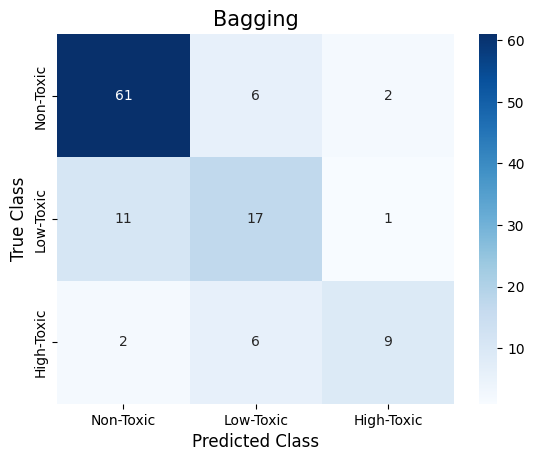

In [34]:
model_7 = BaggingClassifier(
    n_estimators=best_params7['n_estimators'],
    max_samples=best_params7['max_samples'],
    max_features=best_params7['max_features'],
    random_state=0
)

ppl_7 = make_pipeline(smote, model_7)

evaluate_model_3class(ppl_7, X_train, y_train, X_test, y_test, kf, 'Bagging')

#### Random Forest, Bayesian optimization

In [35]:
def black_box_function8(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=int(max_features),
        n_jobs=-1,
        random_state=0
    )
    
    ppl = make_pipeline(smote, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro')

    return cv_score.mean()

pbounds8 = {
    'n_estimators': (50, 500),
    'max_depth': (1, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (1, 30)
}

optimizer8 = BayesianOptimization(
    f=black_box_function8,
    pbounds=pbounds8,
    verbose=2,
    random_state=0
)

optimizer8.maximize(init_points=25,n_iter=75)

best_params8 = optimizer8.max['params']
best_params8['n_estimators'] = round(best_params8['n_estimators'])
best_params8['max_depth'] = round(best_params8['max_depth'])
best_params8['min_samples_split'] = round(best_params8['min_samples_split'])
best_params8['min_samples_leaf'] = round(best_params8['min_samples_leaf'])
best_params8['max_features'] = round(best_params8['max_features'])

print(optimizer8.max)
print(best_params8)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.65      | 16.92     | 21.74     | 12.45     | 11.81     | 240.6     |
| 2         | 0.6602    | 19.73     | 13.69     | 17.94     | 19.35     | 222.5     |
| 3         | 0.6404    | 23.96     | 16.34     | 11.79     | 18.66     | 81.97     |
| 4         | 0.618     | 3.527     | 1.586     | 16.82     | 16.01     | 441.5     |
| 5         | 0.6633    | 29.38     | 24.18     | 9.768     | 16.05     | 103.2     |
| 6         | 0.6525    | 19.56     | 5.157     | 18.95     | 11.39     | 236.6     |
| 7         | 0.648     | 8.672     | 23.45     | 9.667     | 12.23     | 58.46     |
| 8         | 0.6477    | 18.91     | 18.75     | 12.72     | 18.99     | 356.8     |
| 9         | 0.6547    | 11.43     | 13.67     | 14.25     | 3.084     | 350.0     |
| 10        | 0.6665    | 20.45     | 7.101     | 3.45

#### Evaluation

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.77276525 0.63297737 0.73391608 0.73239258 0.58034188 0.7288699
 0.74343434 0.61406785 0.65064619 0.63865546] 

Random Forest's mean result of 10-fold cross-validation is 0.683
Random Forest's Matthews Correlation Coefficient is 0.592 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        69
           1       0.62      0.62      0.62        29
           2       0.65      0.65      0.65        17

    accuracy                           0.77       115
   macro avg       0.71      0.71      0.71       115
weighted avg       0.77      0.77      0.77       115



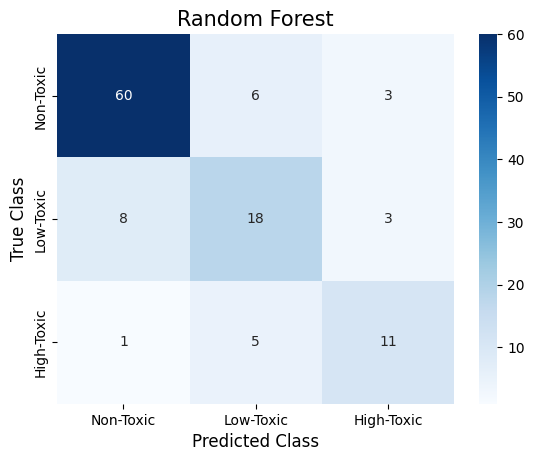

In [36]:
model_8 = RandomForestClassifier(
    n_estimators=best_params8['n_estimators'],
    max_depth=best_params8['max_depth'],
    min_samples_leaf=best_params8['min_samples_leaf'],
    min_samples_split=best_params8['min_samples_split'],
    max_features=best_params8['max_features'],
    n_jobs=-1,
    random_state=0
)

ppl_8 = make_pipeline(smote, model_8)

evaluate_model_3class(ppl_8, X_train, y_train, X_test, y_test, kf, 'Random Forest')

#### GBDT, Bayesian optimization

In [37]:
def black_box_function9(n_estimators, learning_rate, max_depth,
                       max_features, min_samples_split, min_samples_leaf, subsample):
    
    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        subsample=float(subsample),
        random_state=0
    )
    
    ppl = make_pipeline(smote, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro')
    
    return cv_score.mean()

pbounds9 = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.3),
    'max_depth': (1, 30),
    'max_features': (1, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'subsample': (0.1, 1),
}

optimizer9 = BayesianOptimization(
    f=black_box_function9,
    pbounds=pbounds9,
    verbose=2,
    random_state=0
)

optimizer9.maximize(init_points=25,n_iter=75)

best_params9 = optimizer9.max['params']

best_params9['n_estimators'] = round(best_params9['n_estimators'])
best_params9['learning_rate'] = float('%.3g'% best_params9['learning_rate'])
best_params9['max_depth'] = round(best_params9['max_depth'])
best_params9['max_features'] = round(best_params9['max_features'])
best_params9['min_samples_split'] = round(best_params9['min_samples_split'])
best_params9['min_samples_leaf'] = round(best_params9['min_samples_leaf'])
best_params9['subsample'] = float('%.3g'% best_params9['subsample'])

print(optimizer9.max)
print(best_params9)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.689     | 0.1692    | 21.74     | 18.48     | 11.35     | 9.626     | 340.7     | 0.4938    |
| 2         | 0.6837    | 0.2686    | 28.95     | 12.12     | 16.04     | 11.52     | 305.6     | 0.933     |
| 3         | 0.6405    | 0.0306    | 3.527     | 1.586     | 16.82     | 16.01     | 441.5     | 0.9808    |
| 4         | 0.7025    | 0.2418    | 14.38     | 23.64     | 3.247     | 13.52     | 114.5     | 0.9502    |
| 5         | 0.6619    | 0.1613    | 13.03     | 8.672     | 15.71     | 10.21     | 305.8     | 0.1169    |
| 6         | 0.6869    | 0.1891    | 18.75     | 18.89     | 18.93     | 14.27     | 211.8     | 0.4933    |
| 7         | 0.6531    | 0.2123    | 2.747     | 20.34     | 13.74     | 5.787     | 108.0     | 0.3839    |
| 8       

#### Evaluation

GBDT's results of 10-fold cross-validation are as follows: 
 [0.83811231 0.60837438 0.76623377 0.72069667 0.60776014 0.7668566
 0.75321068 0.6547619  0.67169432 0.6792328 ] 

GBDT's mean result of 10-fold cross-validation is 0.707
GBDT's Matthews Correlation Coefficient is 0.613 

GBDT's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        69
           1       0.63      0.59      0.61        29
           2       0.79      0.65      0.71        17

    accuracy                           0.79       115
   macro avg       0.76      0.72      0.73       115
weighted avg       0.79      0.79      0.79       115



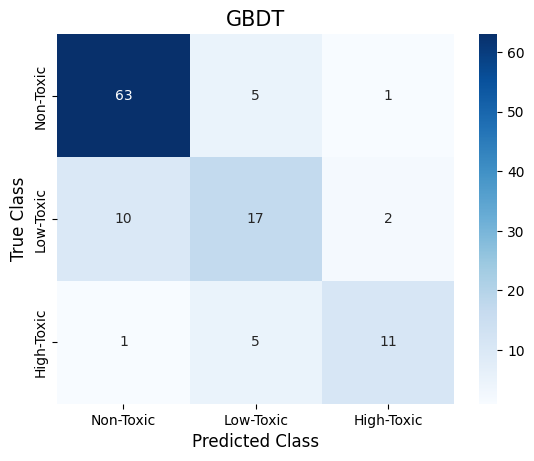

In [39]:
model_9 = GradientBoostingClassifier(
    n_estimators=best_params9['n_estimators'],
    learning_rate=best_params9['learning_rate'],
    max_depth=best_params9['max_depth'],
    max_features=best_params9['max_features'],
    min_samples_split=best_params9['min_samples_split'],
    min_samples_leaf=best_params9['min_samples_leaf'],
    subsample=best_params9['subsample'],
    random_state=0
)

ppl_9 = make_pipeline(smote, model_9)

evaluate_model_3class(ppl_9, X_train, y_train, X_test, y_test, kf, name='GBDT')

#### LightGBM, Bayesian optimization

In [40]:
def black_box_function10(n_estimators, learning_rate, num_leaves, max_depth, min_child_samples,
                       subsample, colsample_bytree, reg_alpha, reg_lambda):
    
    model = LGBMClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        subsample=float(subsample),
        colsample_bytree=float(colsample_bytree),
        reg_alpha=float(reg_alpha),
        reg_lambda=float(reg_lambda),
        verbose=-1,
        n_jobs=-1,
        random_state=0
    )
    
    ppl = make_pipeline(smote, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring='f1_macro')
    
    return cv_score.mean()

pbounds10 = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.3),
    'max_depth': (1, 30),
    'num_leaves': (2, 1024),
    'min_child_samples': (1, 50),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1)
}

optimizer10 = BayesianOptimization(
    f=black_box_function10,
    pbounds=pbounds10,
    verbose=2,
    random_state=0
)

optimizer10.maximize(init_points=25,n_iter=75)

best_params10 = optimizer10.max['params']
best_params10['n_estimators'] = round(best_params10['n_estimators'])
best_params10['learning_rate'] = float('%.3g'%best_params10['learning_rate'])
best_params10['max_depth'] = round(best_params10['max_depth'])
best_params10['num_leaves'] = round(best_params10['num_leaves'])
best_params10['min_child_samples'] = round(best_params10['min_child_samples'])
best_params10['subsample'] = float('%.3g'%best_params10['subsample'])
best_params10['colsample_bytree'] = float('%.3g'%best_params10['colsample_bytree'])
best_params10['reg_alpha'] = float('%.3g'%best_params10['reg_alpha'])
best_params10['reg_lambda'] = float('%.3g'%best_params10['reg_lambda'])

print(optimizer10.max)
print(best_params10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6818    | 0.5939    | 0.2174    | 18.48     | 27.7      | 240.6     | 662.1     | 0.4376    | 0.8918    | 0.9673    |
| 2         | 0.6816    | 0.4451    | 0.2396    | 16.34     | 28.83     | 466.5     | 74.6      | 0.08713   | 0.02022   | 0.8494    |
| 3         | 0.6802    | 0.8003    | 0.2623    | 29.38     | 40.16     | 257.7     | 799.7     | 0.1183    | 0.6399    | 0.229     |
| 4         | 0.6694    | 0.9502    | 0.1613    | 13.03     | 13.96     | 398.4     | 468.2     | 0.5684    | 0.01879   | 0.6559    |
| 5         | 0.6748    | 0.6509    | 0.1889    | 28.37     | 34.41     | 211.8     | 448.6     | 0.6976    | 0.06023   | 0.7001    |
| 6         | 0.6722    | 0.7036    | 0.07101   | 4.739     | 

#### Evaluation

LightGBM's results of 10-fold cross-validation are as follows: 
 [0.77371445 0.58888889 0.77259052 0.74603175 0.59541446 0.7668566
 0.72815813 0.59920635 0.70407999 0.7281746 ] 

LightGBM's mean result of 10-fold cross-validation is 0.7
LightGBM's Matthews Correlation Coefficient is 0.617 

LightGBM's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        69
           1       0.64      0.62      0.63        29
           2       0.73      0.65      0.69        17

    accuracy                           0.79       115
   macro avg       0.75      0.72      0.73       115
weighted avg       0.79      0.79      0.79       115



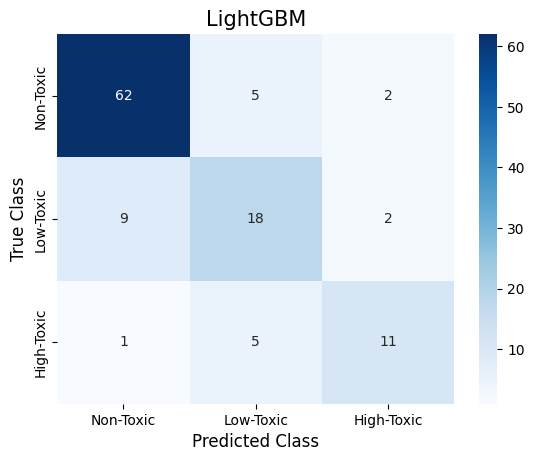

In [41]:
model_10 = LGBMClassifier(
    n_estimators=best_params10['n_estimators'],
    learning_rate=best_params10['learning_rate'],
    max_depth=best_params10['max_depth'],
    num_leaves=best_params10['num_leaves'],
    subsample=best_params10['subsample'],
    colsample_bytree=best_params10['colsample_bytree'],
    min_child_samples=best_params10['min_child_samples'],
    reg_alpha=best_params10['reg_alpha'],
    reg_lambda=best_params10['reg_lambda'],
    n_jobs=-1, verbosity=-1, random_state=0
)

ppl_10 = make_pipeline(smote, model_10)

evaluate_model_3class(ppl_10, X_train, y_train, X_test, y_test, kf, 'LightGBM')

#### Use K-nearest Neighbor method to define the applicability domain

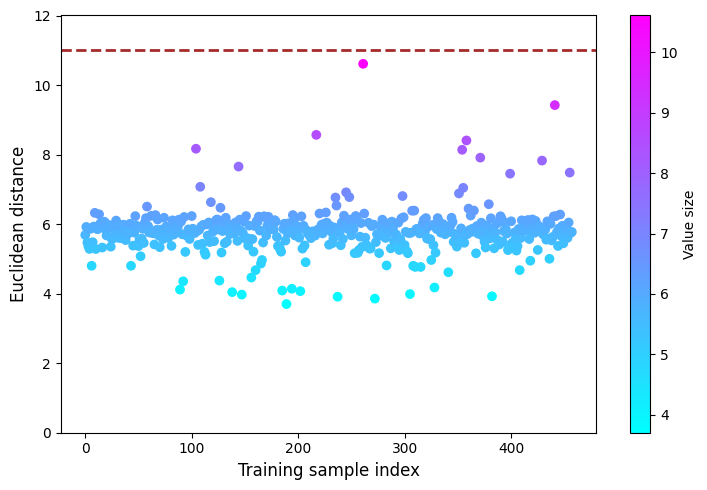

In [42]:
train_set_numeric = np.array(X_train)

k_neighbors = 3
DT_values = calculate_DT(train_set_numeric, k_neighbors)

threshold = 11

plt.figure(figsize=(7.5, 5))
plt.scatter(range(len(DT_values)), DT_values, c=DT_values, cmap='cool')
plt.axhline(y=threshold, color='brown', linestyle='--', linewidth=2)
plt.colorbar(label='Value size')
plt.xlabel('Training sample index', fontsize=12)
plt.ylabel('Euclidean distance', fontsize=12)
plt.ylim(0, 12)
plt.tight_layout()
plt.savefig('三分类适用性域.png', dpi=300)

plt.show()

# 找到并输出异常值所在的行
for i, dt in enumerate(DT_values):
    if dt > threshold:
        print(f"异常值所在的行：{i}，DT值：{dt}")

#### Observe whether the samples in the test set are contained within the applicability domain

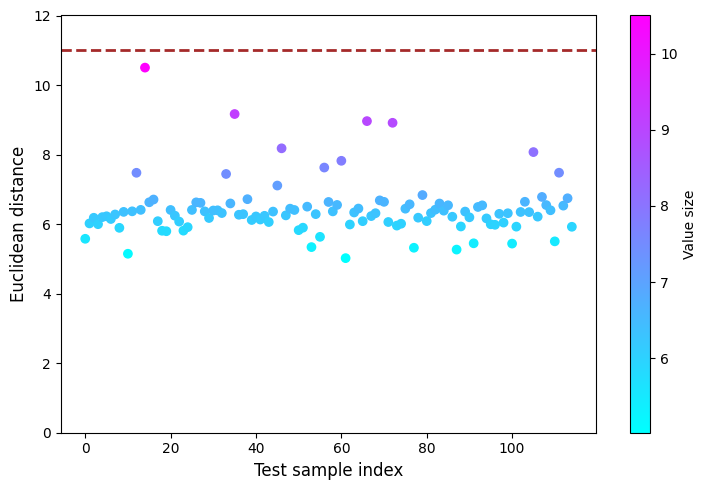

In [43]:
test_set_numeric = np.array(X_test)
DT_values_test = calculate_DT(test_set_numeric, k_neighbors)

plt.figure(figsize=(7.5, 5))
plt.scatter(range(len(DT_values_test)), DT_values_test, c=DT_values_test, cmap='cool')
plt.axhline(y=threshold, color='brown', linestyle='--', linewidth=2)
plt.colorbar(label='Value size')
plt.xlabel('Test sample index', fontsize=12)
plt.ylabel('Euclidean distance', fontsize=12)
plt.ylim(0, 12)
plt.tight_layout()
plt.savefig('三分类适用性域（测试集）.png', dpi=300)

plt.show()

# 找到并输出异常值所在的行
for i, dt in enumerate(DT_values_test):
    if dt > threshold:
        print(f"异常值所在的行：{i}，DT值：{dt}")

#### Use pickle to save the models

In [44]:
clfs = [ppl_10, ppl_9, ppl_8, ppl_7, ppl_6, ppl_5, ppl_4, ppl_3, ppl_2, ppl_1]

clfnames = ['LightGBM_3class_modred', 'GBDT_3class_modred', 'RF_3class_modred', 'Bagging_3class_mordred',
            'DT_3class_mordred', 'SVC_3class_modred', 'KNN_3class_modred', 'GNB_3class_modred',
            'LDA_3class_modred', 'LR_3class_mordred']

for clf, name in zip(clfs, clfnames):
    with open(name, 'wb') as f:
        pickle.dump(clf, f)

#### Use pickle to load the models

In [45]:
loaded_models = []

clfnames = ['LightGBM_3class_modred', 'GBDT_3class_modred', 'RF_3class_modred', 'Bagging_3class_mordred',
            'DT_3class_mordred', 'SVC_3class_modred', 'KNN_3class_modred', 'GNB_3class_modred',
            'LDA_3class_modred', 'LR_3class_mordred']

for name in clfnames:
    with open(name, 'rb') as f:
        model = pickle.load(f)
        loaded_models.append(model)

#### Verify that the imported models are correct; export the results of the ten-fold cross-validation to R for plotting

In [83]:
modelnames = ['LightGBM', 'GBDT', 'RF', 'Bagging', 'DT', 'SVC', 'KNN', 'GNB', 'LDA', 'LR']

df_cv_scores = {}

for model, name in zip(loaded_models, modelnames):

    y_predict = model.predict(X_test)

    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_macro')
    df_cv_scores[name] = cv_scores
    f1_macro = cv_scores.mean()
    report = classification_report(y_test, y_predict)

    print(f'{name}\'s 10-fold cross-validation results:\n{cv_scores}')
    print(f'\n{name}\'s macro F1-score is {f1_macro:.3g} (training set)')
    print(f'{name}\'s classification report:\n{report}')
    print('='*75)

df_cv_scores = pd.DataFrame(df_cv_scores)
df_cv_scores.to_csv('training set accuracy Mordred 3class.csv', index=False, encoding='utf-8')

LightGBM's 10-fold cross-validation results:
[0.77371445 0.58888889 0.77259052 0.74603175 0.59541446 0.7668566
 0.72815813 0.59920635 0.70407999 0.7281746 ]

LightGBM's macro F1-score is 0.7 (training set)
LightGBM's classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        69
           1       0.64      0.62      0.63        29
           2       0.73      0.65      0.69        17

    accuracy                           0.79       115
   macro avg       0.75      0.72      0.73       115
weighted avg       0.79      0.79      0.79       115

GBDT's 10-fold cross-validation results:
[0.83811231 0.60837438 0.76623377 0.72069667 0.60776014 0.7668566
 0.75321068 0.6547619  0.67169432 0.6792328 ]

GBDT's macro F1-score is 0.707 (training set)
GBDT's classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        69
           1       0.63      0.59      0

#### Plotting the confusion matrices for the four best models

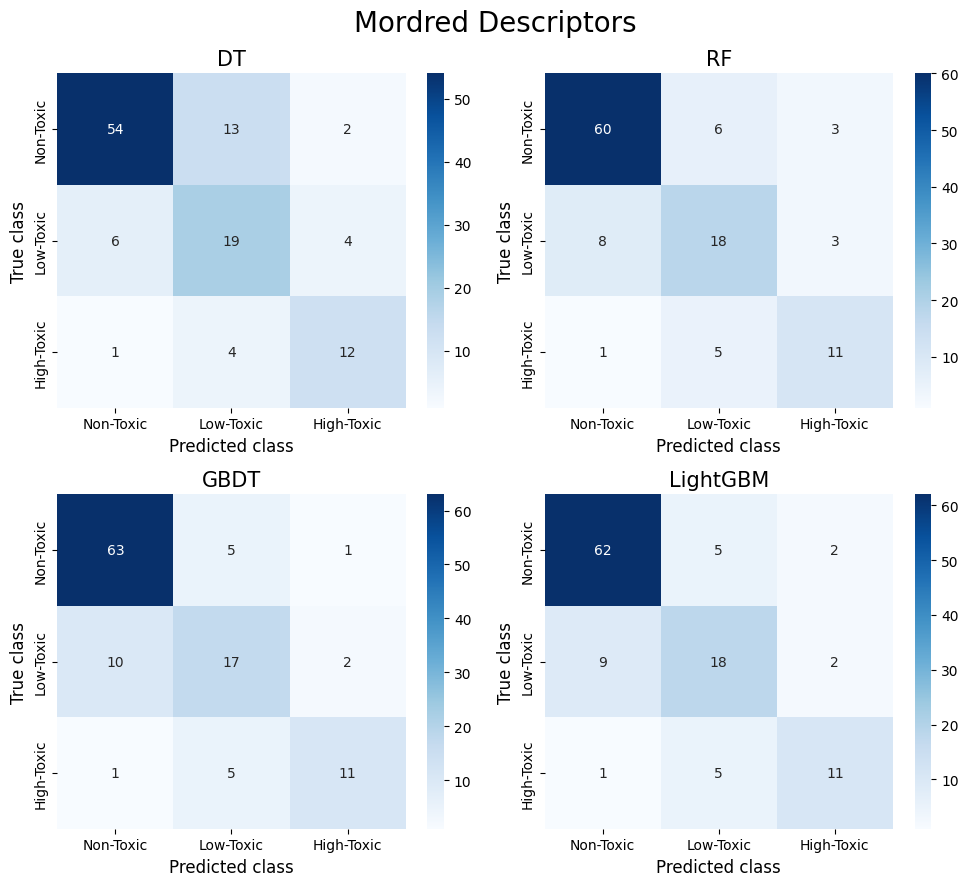

In [61]:
best_models = []
clfnames = ['DT_3class_mordred', 'RF_3class_modred', 'GBDT_3class_modred', 'LightGBM_3class_modred']

for name in clfnames:
    with open(name, 'rb') as f:
        model = pickle.load(f)
        best_models.append(model)
        
best_modelnames = ['DT', 'RF', 'GBDT', 'LightGBM']
conf_matrices = []

for model, name in zip(best_models, best_modelnames):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Non-Toxic', 'Low-Toxic', 'High-Toxic']
    conf_matrix = pd.DataFrame(cm, index=classes, columns=classes)
    conf_matrices.append(conf_matrix)

fig, axs = plt.subplots(2, 2, figsize=(10, 9))

for i, (ax, conf_matrix, modelname) in enumerate(zip(axs.flatten(), conf_matrices, best_modelnames)):
    
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size":10}, cmap="Blues", ax=ax)  
    ax.set_title(modelname, fontsize=15)  
    ax.set_ylabel('True class', fontsize=12)  
    ax.set_xlabel('Predicted class', fontsize=12)  

plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle('Mordred Descriptors', fontsize=20)
plt.tight_layout()
plt.savefig('Mordred三分类模型混淆矩阵.png', dpi=300, bbox_inches='tight')

plt.show()

#### Construct a voting model and evaluate (give the GBDT model the highest weight since it has the highest recall)

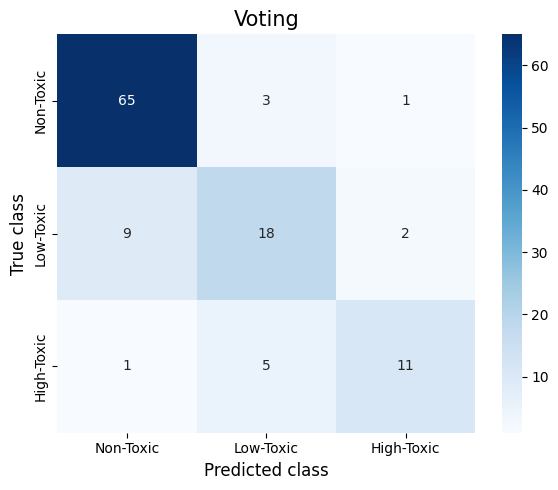

In [77]:
estimators = [('DT', best_models[3]),
              ('RF', best_models[2]),
              ('GBDT', best_models[1]),
              ('LightGBM', best_models[0])]

model_voting = VotingClassifier(estimators=estimators)

model_voting.fit(X_train, y_train)
y_pred = model_voting.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
classes = ['Non-Toxic', 'Low-Toxic', 'High-Toxic']
conf_matrix = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size":10}, cmap="Blues")

plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.title('Voting', fontsize=15)
plt.tight_layout()
plt.savefig('Voting.png', dpi=300)

plt.show()

Voting's results of 10-fold cross-validation are as follows: 
 [0.86449046 0.6622276  0.76379354 0.78179092 0.60776014 0.7668566
 0.76623377 0.6245614  0.72839506 0.6792328 ] 

Voting's mean result of 10-fold cross-validation is 0.725
Voting's Matthews Correlation Coefficient is 0.661 

Voting's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        69
           1       0.69      0.62      0.65        29
           2       0.79      0.65      0.71        17

    accuracy                           0.82       115
   macro avg       0.78      0.74      0.76       115
weighted avg       0.81      0.82      0.81       115



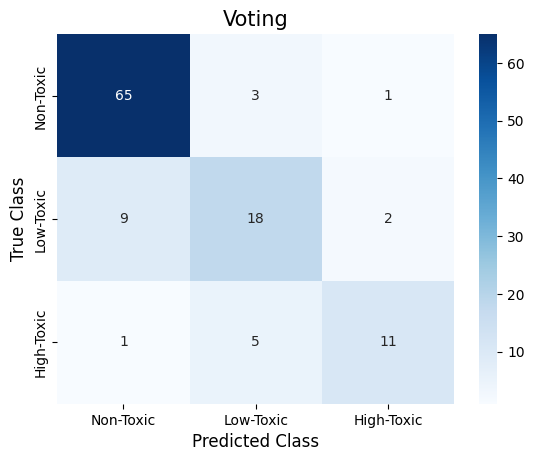

In [79]:
evaluate_model_3class(model_voting, X_train, y_train, X_test, y_test, kf, name='Voting')

#### Using SHAP to explain the output of the LightGBM model

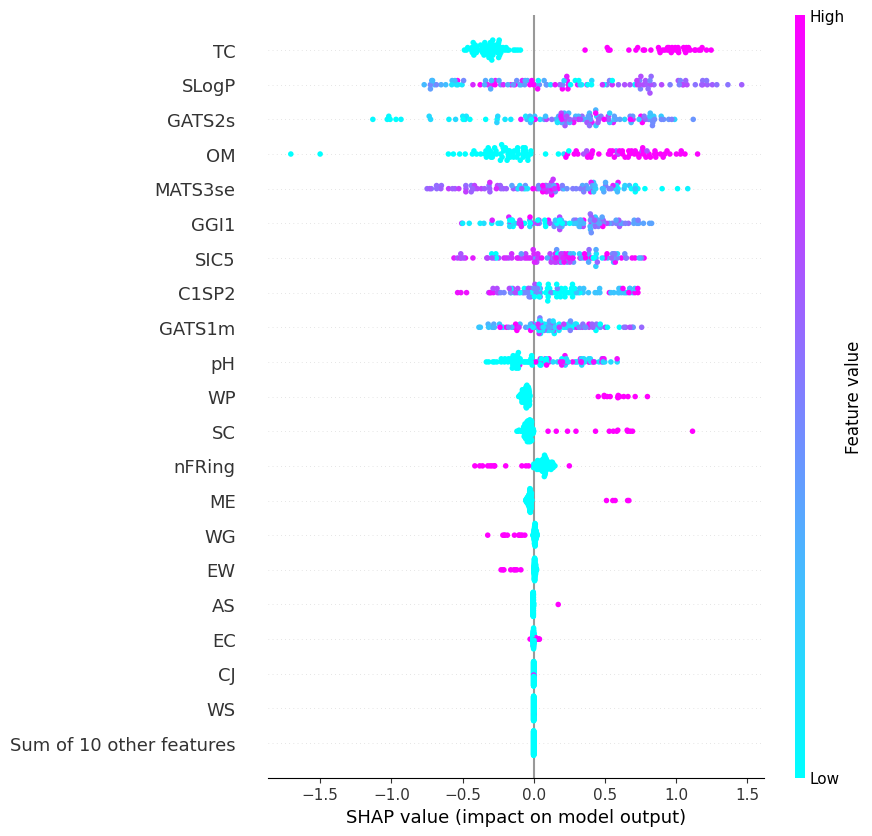

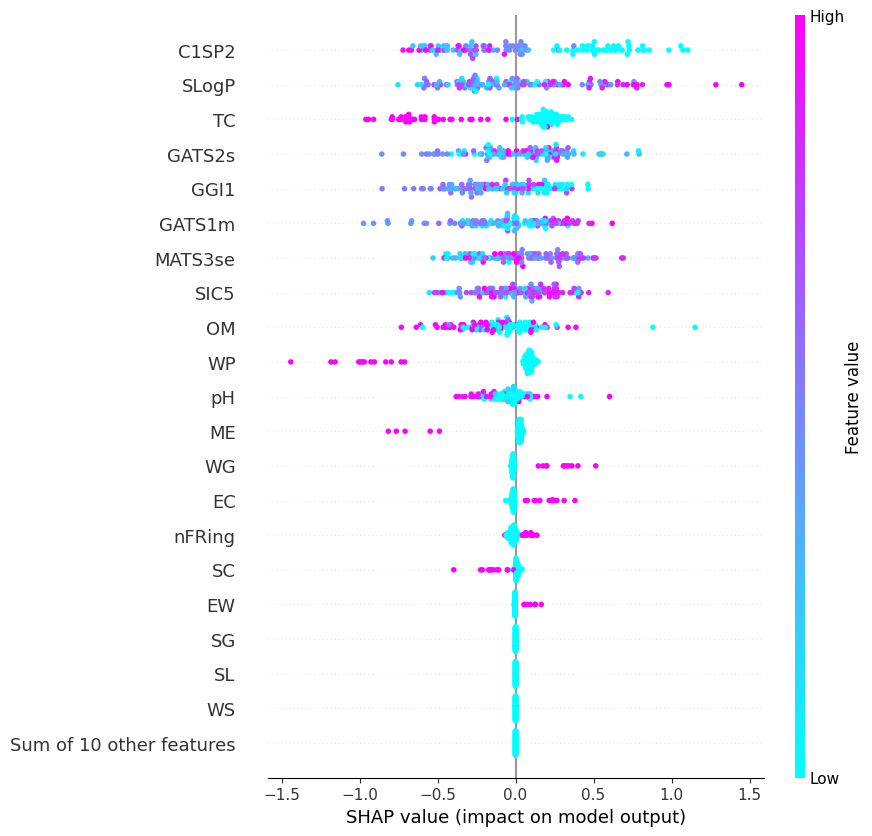

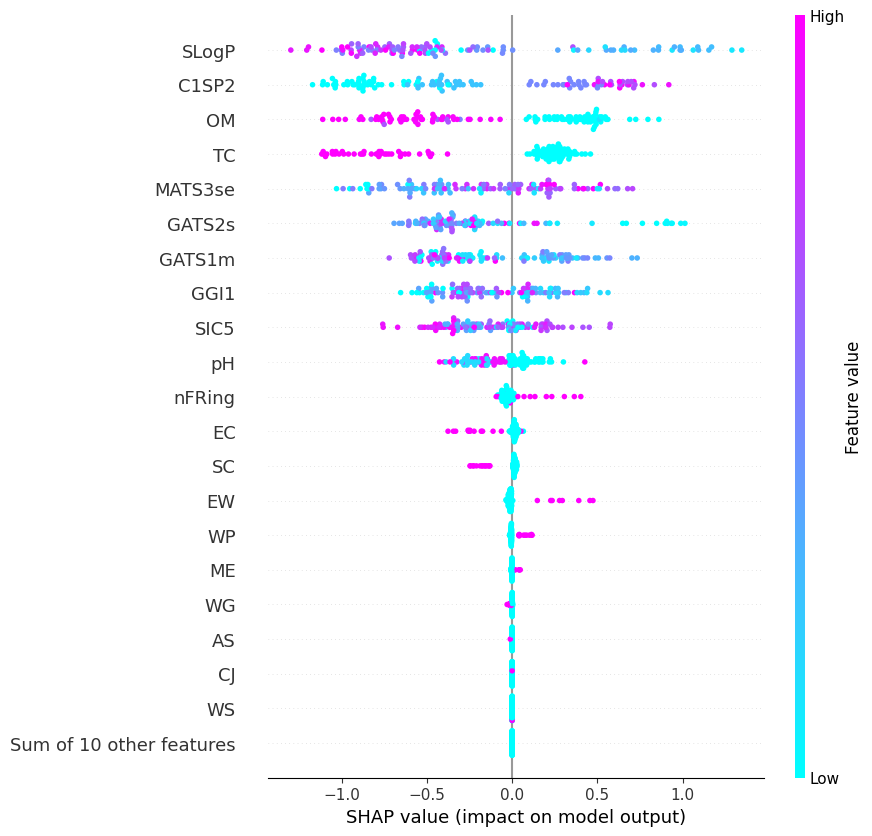

In [54]:
model = best_models[0][1]

explainer = shap.TreeExplainer(model)
shap_values_test = explainer(X_test)

plt.figure()
shap.plots.beeswarm(shap_values_test[:, :, 0], max_display=21, color=plt.get_cmap("cool"), show=False)
plt.savefig("三分类0.png", bbox_inches='tight')

plt.figure()
shap.plots.beeswarm(shap_values_test[:, :, 1], max_display=21, color=plt.get_cmap("cool"), show=False)
plt.savefig("三分类1.png", bbox_inches='tight')

plt.figure()
shap.plots.beeswarm(shap_values_test[:, :, 2], max_display=21, color=plt.get_cmap("cool"), show=False)
plt.savefig("三分类2.png", bbox_inches='tight')

plt.show()